#Install the Packages
gurobipy, epyt, numpy, matlplotlib, pandas

In [1]:
pip install epyt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 9.4 MB/s eta 0:00:00


In [2]:
pip install gurobipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 43.2 MB/s eta 0:00:00


In [3]:
from epyt import epanet
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gurobipy as gp
import time
from gurobipy import GRB

# Define required functions
water_quality_simulation --> Simulate water quality using EPANET.


PositiveDemandNodeIndices --> Obtain the demand nodes with positive base demand values to act as a water quality sensor nodes

In [4]:
def water_quality_simulation(d, optimal_schedule, booster_station_indices, demand_nodes, source_injection_rate, bk):
    """
    Simulate water quality using EPANET.

    Parameters:
        d (epanet object): EPANET object for simulation.
        optimal_schedule (np.ndarray): Optimal booster station schedule.
        booster_station_indices (list): Indices of booster stations.
        demand_nodes (list): Indices of demand nodes.
        source_injection_rate (float): Injection rate of the source (mg/min).
        bk (float): Bulk reaction coefficient.

    Returns:
        np.ndarray: Residual chlorine concentrations at demand nodes.
    """
    num_booster_stations = len(booster_station_indices)
    schedule_matrix = optimal_schedule.reshape(24, num_booster_stations)
    simulation_duration_hours = 480
    pattern_time_step_seconds = 3600

    # Set simulation parameters
    d.setTimeSimulationDuration(simulation_duration_hours * 3600)
    d.setQualityType('chem', 'mg/L')
    d.setTimeQualityStep(300)
    d.setNodeInitialQuality([0] * d.getNodeCount())
    d.setLinkBulkReactionCoeff([bk] * d.getLinkCount())
    d.setLinkWallReactionCoeff([0] * d.getLinkCount())

    node_count = d.getNodeCount()
    source_pattern_indices = [0] * node_count
    source_qualities = [0] * node_count

    # Configure booster stations
    for i, booster_station in enumerate(booster_station_indices):
        pattern = d.addPattern(f'CHLORINEDOSE_Optimal_{booster_station}', schedule_matrix[:, i])
        time.sleep(0.1)
        source_pattern_indices[booster_station] = pattern
        time.sleep(0.1)
        source_qualities[booster_station] = source_injection_rate
        time.sleep(0.1)

    d.setNodeSourceType(booster_station_indices[-1] + 1, 'MASS')
    d.setNodeSourcePatternIndex(source_pattern_indices)
    d.setNodeSourceQuality(source_qualities)

    # Run simulation and collect results
    results = d.getComputedQualityTimeSeries()
    node_quality = results.NodeQuality
    df = pd.DataFrame(node_quality, columns=d.getNodeNameID(), index=results.Time)
    filtered_df = df[df.index % pattern_time_step_seconds == 0].tail(24)
    residual_chlorine_nodes = np.array(filtered_df)[:, demand_nodes]

    return residual_chlorine_nodes.reshape(24, len(demand_nodes))

def PositiveDemandNodeIndices(arr):
    positive_indices = []
    for i in range(len(arr)):
        if arr[i] > 0:
            positive_indices.append(i)
    return positive_indices

# Intitialize the generation of response matrix (B)



In [5]:
d = epanet('Net2.inp')
BK = -0.9
NN = d.getNodeCount()
NP = d.getLinkCount()
NR = d.getNodeReservoirCount()
NT = d.getNodeTankCount()
RI = d.getNodeReservoirIndex()
TI = d.getNodeTankIndex()
Pat = d.getNodeDemandPatternIndex()
PaternArray = d.getPattern()
d.getNodeReservoirNameID()

# Booster Chlorination Node IDS
BaseDemands = d.getNodeBaseDemands()
BoosterStationNodeIDs = ['1']
WQSensorIndices =PositiveDemandNodeIndices(BaseDemands[1])

NodeNameIDs = d.getNodeNameID()
NodeIndex = d.getNodeIndex()
BoosterStationIndices = [NodeNameIDs.index(value) for value in BoosterStationNodeIDs]
WQSensorNodesIDs = [NodeNameIDs[value] for value in WQSensorIndices]

d.getPattern()
duration = 480  #hours
patern_time_step = 3600  # in seconds
d.setTimeSimulationDuration(duration * 3600)

DemandNodes = WQSensorIndices
# Set quality type & units
quality_type = 'chem'
quality_units = 'mg/L'
d.setQualityType(quality_type, quality_units)
d.setTimeQualityStep(300)

zeroNodes = [0]*NN
d.setNodeInitialQuality(zeroNodes)
d.setLinkBulkReactionCoeff([BK] * NP)
d.setLinkWallReactionCoeff([0] * NP)

patlen = 24* 3600 / patern_time_step

'''
RESPONSE MATRICES GENERATION
'''

source_injection_rate  = 10000 #mg/min
BoosterStationRM = []
for BS in BoosterStationIndices:
    ResposeMatrix = []
    for n in list(range(1,25,1)):
        zeroNodes = [0]*NN
        print('BoosterStation: ', str(BS), 'Hour: ',str(n))
        tmp = [0]*int(patlen)
        tmpstartstep = n-1
        tmpendstep = n
        tmp[tmpstartstep:tmpendstep] = [1] * (tmpendstep - tmpstartstep)
        Pat1 = d.addPattern('CHLORINEDOSE' + str(BS) + str (n), tmp)
        tmp2 = zeroNodes
        tmp2[BS] = Pat1
        d.setNodeSourceType(BS+1, 'MASS')
        d.setNodeSourcePatternIndex(tmp2)
        tmp2 = zeroNodes
        tmp2[BS] = source_injection_rate
        d.setNodeSourceQuality(tmp2)
        res = d.getComputedQualityTimeSeries()
        RC_Nodes = res.NodeQuality
        df = pd.DataFrame(RC_Nodes)
        df.columns = d.getNodeNameID()
        df.index = res.Time
        filtered_df = df[df.index % 3600 == 0]
        filtered_df = filtered_df.tail(24)
        array = np.array(filtered_df)
        Req_RC_Nodes = array[:, DemandNodes]
        Req_RC_Nodes = np.array(Req_RC_Nodes)
        ResposeMatrix.append(Req_RC_Nodes)
    BoosterStationRM.append(ResposeMatrix)
# all the respose matrices are saved in the lists of array BoosterStationRM
sample = np.array(BoosterStationRM[0][0].reshape(24,len(DemandNodes)))
BoosterStationRMEN = []
for b in np.arange(len(BoosterStationRM)):
    ResponeMatrixGenerationForEachNode = []
    for n in np.arange(len(sample[0,:])):
        RMforNode=np.zeros((len(sample[:,0]),len(sample[:,0])))
        for h in np.arange(len(sample[:,0])):
            h = int(h)
            arr = np.array(BoosterStationRM[b][h].reshape(24,len(DemandNodes)))
            RMforNode[:,h] = arr[:,n]
        ResponeMatrixGenerationForEachNode.append(RMforNode)
    BoosterStationRMEN.append(ResponeMatrixGenerationForEachNode)

PF_Parameters = [0.2,0.8,0.4,-40,40,0.6]
[num1, num2, num3, num4, num5, num6] = PF_Parameters
ListOfArrays =  BoosterStationRMEN

LargeMatrix = np.zeros((24*len(DemandNodes),len(BoosterStationIndices)*24),dtype = float)

for b in range(len(BoosterStationIndices)):
    for n in range(len(DemandNodes)):
        LargeMatrix[24*n:(24*(n+1)),24*b:(24*(b+1))] = ListOfArrays[b][n]

## Here the LargeMatrix is the response matrix

EPANET version 20200 loaded (EPyT version v1.1.9 - Last Update: 24/06/2024).
Input File Net2.inp loaded successfully.

BoosterStation:  0 Hour:  1
BoosterStation:  0 Hour:  2
BoosterStation:  0 Hour:  3
BoosterStation:  0 Hour:  4
BoosterStation:  0 Hour:  5
BoosterStation:  0 Hour:  6
BoosterStation:  0 Hour:  7
BoosterStation:  0 Hour:  8
BoosterStation:  0 Hour:  9
BoosterStation:  0 Hour:  10
BoosterStation:  0 Hour:  11
BoosterStation:  0 Hour:  12
BoosterStation:  0 Hour:  13
BoosterStation:  0 Hour:  14
BoosterStation:  0 Hour:  15
BoosterStation:  0 Hour:  16
BoosterStation:  0 Hour:  17
BoosterStation:  0 Hour:  18
BoosterStation:  0 Hour:  19
BoosterStation:  0 Hour:  20
BoosterStation:  0 Hour:  21
BoosterStation:  0 Hour:  22
BoosterStation:  0 Hour:  23
BoosterStation:  0 Hour:  24


# Define the optimization problem
Using gurobipy define the optimization model.

Objective Fucntion is to minimize the total mass injected into the system.

Constraint are that the residual chlorine should be within the regulation limits.

For this tutorial only one booster station is considered, but the same code can be used for multiple booster stations with minimal modifications.

Note: gurobi license might be required to solve a larger problem, but student license is free in the [gurobi website](https://www.gurobi.com/features/academic-named-user-license/).


In [6]:
'''
//////////////////////////////////////////////////////////////////////////////
Gurobi Optimization Model
'''

## Regulation Limits
Lower_Regulation_Limit = 0.3 #(mg/l)
Upper_Regulation_Limit = 2 #(mg/l)

## Optimization Objective: Minimize the mass injected into the system
## Constraints: Residual Chlorine Concentration in the demand nodes are within the regulation limits
## Using Linear Superpositon Methodology using response matrix as a surrogate for epanet-water quality simmulation
## to facilitate linear programming approch refer:
## Boccelli, D. L., Tryby, M. E., Uber, J. G., Rossman, L. A., Zierolf, M. L., & Polycarpou, M. M. (1998).
## Optimal scheduling of booster disinfection in water distribution systems.
## Journal of water resources planning and management, 124(2), 99-111.



## Initialize gurobipy packages

import gurobipy as gp
from gurobipy import GRB

# Create a new model
model = gp.Model("Optimization_program")

#Define Decision Variables
num_of_dimentions = len(BoosterStationIndices)*24
x = {}
for i in range(num_of_dimentions):
    x[i] = model.addVar(lb = 0.0, ub = 1000.0, vtype=GRB.CONTINUOUS, name= f'x{i}')

# Define Constraints
RC = {}

for i in range(LargeMatrix.shape[0]):
    Equ_expr = gp.LinExpr()
    for j in range(LargeMatrix.shape[1]):
        Equ_expr += LargeMatrix[i, j] * x[j]
    RC[i] = Equ_expr
    model.addConstr(RC[i] <= Upper_Regulation_Limit) # Hard Constriants on the residual chlorine
    model.addConstr(Lower_Regulation_Limit<= RC[i])


obj_expr = gp.LinExpr()
for j in range(num_of_dimentions):
    obj_expr += x[j]

model.setObjective(obj_expr,GRB.MINIMIZE)

model.optimize()

if model.status == GRB.OPTIMAL:
        print("Optimal solution found!")
else:
    print("No_Optimal_Value_found")

# Save the optimal values of x
optimal_BoosterInjection_values = [x[i].x for i in range(num_of_dimentions)]
OptimalSchedule = np.array(optimal_BoosterInjection_values)
DemandNodes = np.array([DemandNodes])




Restricted license - for non-production use only - expires 2025-11-24


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 1536 rows, 24 columns and 35868 nonzeros
Model fingerprint: 0x127c2c74
Coefficient statistics:
  Matrix range     [9e-12, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+03, 1e+03]
  RHS range        [3e-01, 2e+00]
Presolve removed 1112 rows and 0 columns
Presolve time: 0.03s
Presolved: 424 rows, 101 columns, 10242 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -9.1331828e+04   2.414998e+06   0.000000e+00      0s
      33    8.3117214e+00   0.000000e+00   0.000000e+00      0s

Solved in 33 iterations and 0.05 seconds (0.01 work units)
Optimal objective  8.311721365e+00
Optimal solution found!


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bo

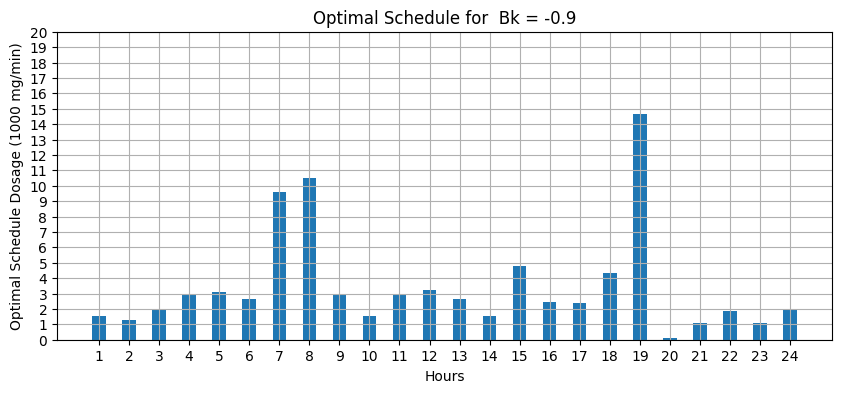

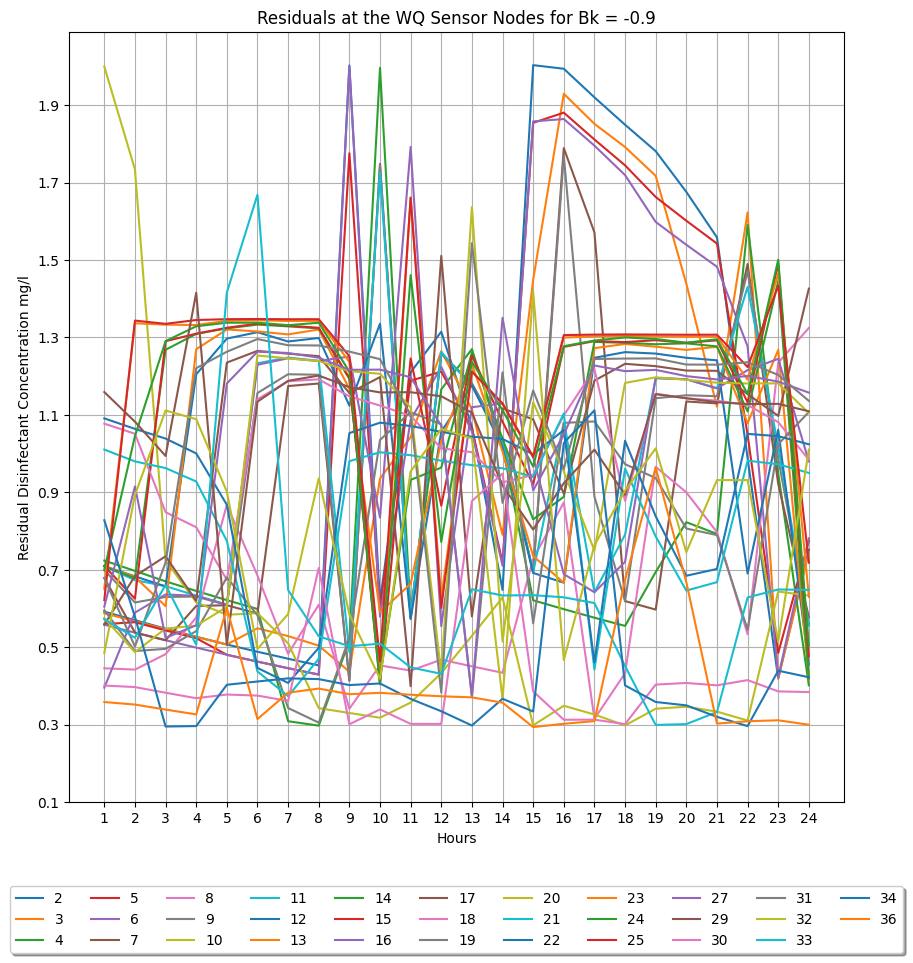

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


In [7]:
'''
CHECK THE RESULTS USING THE OBTAINED OPTIMAL DOSAGE SCHEDULE
'''
RC_Req_NodeData = water_quality_simulation(d, OptimalSchedule, BoosterStationIndices, DemandNodes[0],source_injection_rate,BK)

## This is using EPANET Water Quality Simmulaiton
'''
PLOTS OF THE RESULTS
'''
#OPTIMAL SCHEUDLE PLOT
plt.figure(figsize=(10,4))
plt.bar(np.arange(1,25,1),10*OptimalSchedule,width=0.45)
plt.xlabel('Hours')
plt.ylabel('Optimal Schedule Dosage (1000 mg/min)')
plt.xticks(np.arange(1,25,1))
plt.yticks(np.arange(0,21,1))
plt.title('Optimal Schedule for  Bk = '+str(BK))
plt.grid()
plt.show()


# Plot for Residual Chlorine Values
plt.figure(figsize=(10,10))
for i in range(RC_Req_NodeData.shape[1]):
    plt.plot(np.arange(1,25,1), RC_Req_NodeData[:,i], label = WQSensorNodesIDs[i])
plt.title("Residuals at the WQ Sensor Nodes for Bk = " + str(BK))
plt.xticks(np.arange(1,25,1))
plt.yticks(np.arange(0.1,2.1,0.2))
plt.xlabel('Hours')
plt.ylabel("Residual Disinfectant Concentration mg/l")
plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), shadow=True, ncol=11, fancybox=True)
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
